In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical

In [2]:
def load_and_preprocess_image(img_path, ann_path):
    import cv2  # Ensure cv2 is imported within the function scope
    img_path = img_path.numpy().decode('utf-8')
    ann_path = ann_path.numpy().decode('utf-8')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 64))
    ann = cv2.imread(ann_path, 0)
    ann = cv2.resize(ann, (128, 64), interpolation=cv2.INTER_NEAREST)
    
    ann = np.clip(ann, 0, 29)
    ann = to_categorical(ann, num_classes=30)
    
    return img.astype(np.float32) / 255.0, ann.astype(np.float32)

def create_tf_dataset(image_files, annotation_files, batch_size):
    def parse_function(img_path, ann_path):
        img, ann = tf.py_function(
            load_and_preprocess_image, 
            [img_path, ann_path], 
            [tf.float32, tf.float32]
        )
        img.set_shape((64, 128, 3))
        ann.set_shape((64, 128, 30))
        return img, ann
    
    dataset = tf.data.Dataset.from_tensor_slices((image_files, annotation_files))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def get_matched_files(image_dir, annotation_dir, img_suffix, ann_suffix):
    image_files = {}
    annotation_files = {}
    for dirpath, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if filename.endswith(img_suffix):
                base_name = filename.replace(img_suffix, '')
                full_path = os.path.join(dirpath, filename)
                image_files[base_name] = full_path
    for dirpath, _, filenames in os.walk(annotation_dir):
        for filename in filenames:
            if filename.endswith(ann_suffix):
                base_name = filename.replace(ann_suffix, '')
                full_path = os.path.join(dirpath, filename)
                annotation_files[base_name] = full_path
    matched_images = []
    matched_annotations = []
    for base_name, img_path in image_files.items():
        ann_path = annotation_files.get(base_name)
        if ann_path:
            matched_images.append(img_path)
            matched_annotations.append(ann_path)
        else:
            print(f"Warning: No matching annotation file for {img_path}")
    return matched_images, matched_annotations


In [3]:
model = load_model('/home/maith/Desktop/Cityscapes/models/cityScapes.keras')

In [4]:
# Assume get_matched_files and create_tf_dataset are defined or imported
image_files_val, annotation_files_val = get_matched_files(
    image_dir='/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/val',
    annotation_dir='/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/val',
    img_suffix='_leftImg8bit.png',
    ann_suffix='_gtFine_color.png'
)
validation_dataset = create_tf_dataset(image_files_val, annotation_files_val, batch_size=2)

In [5]:
results = model.evaluate(validation_dataset)
print("Validation Loss: {:.4f}, Validation Accuracy: {:.4%}".format(results[0], results[1]))

250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 198ms/step - accuracy: 0.9374 - loss: 0.1916
Validation Loss: 0.2422, Validation Accuracy: 92.1305%


In [6]:
y_pred = []
y_true = []

for img, ann in validation_dataset:
    preds = model.predict(img)
    preds = np.argmax(preds, axis=-1)
    true_labels = np.argmax(ann.numpy(), axis=-1)
    
    y_pred.extend(preds.flatten())
    y_true.extend(true_labels.flatten())

# Calculate precision, recall, and F1-score
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2024-06-26 01:46:02.718789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/maith/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maith/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.94      0.69      0.79    416183
           7       0.00      0.00      0.00     10771
          10       0.00      0.00      0.00       208
          12       0.00      0.00      0.00       778
          16       0.61      0.75      0.67    232419
          26       0.00      0.00      0.00      2827
          29       0.95      0.96      0.96   3432814

    accuracy                           0.92   4096000
   macro avg       0.36      0.34      0.35   4096000
weighted avg       0.92      0.92      0.92   4096000



/home/maith/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.69      0.79    416183
           7       0.00      0.00      0.00     10771
          10       0.00      0.00      0.00       208
          12       0.00      0.00      0.00       778
          16       0.61      0.75      0.67    232419
          26       0.00      0.00      0.00      2827
          29       0.95      0.96      0.96   3432814

    accuracy                           0.92   4096000
   macro avg       0.36      0.34      0.35   4096000
weighted avg       0.92      0.92      0.92   4096000



In [12]:
image_dir_test = '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/val'
annotation_dir_test = '/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/val'
img_suffix = '_leftImg8bit.png'
ann_suffix = '_gtFine_color.png'

image_files_test, annotation_files_test = get_matched_files(image_dir_test, annotation_dir_test, img_suffix, ann_suffix)
test_dataset = create_tf_dataset(image_files_test, annotation_files_test, batch_size=1)

In [13]:
results = model.evaluate(test_dataset)
print("Validation Loss: {:.4f}, Validation Accuracy: {:.4%}".format(results[0], results[1]))

500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.9374 - loss: 0.1913
Validation Loss: 0.2422, Validation Accuracy: 92.1305%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


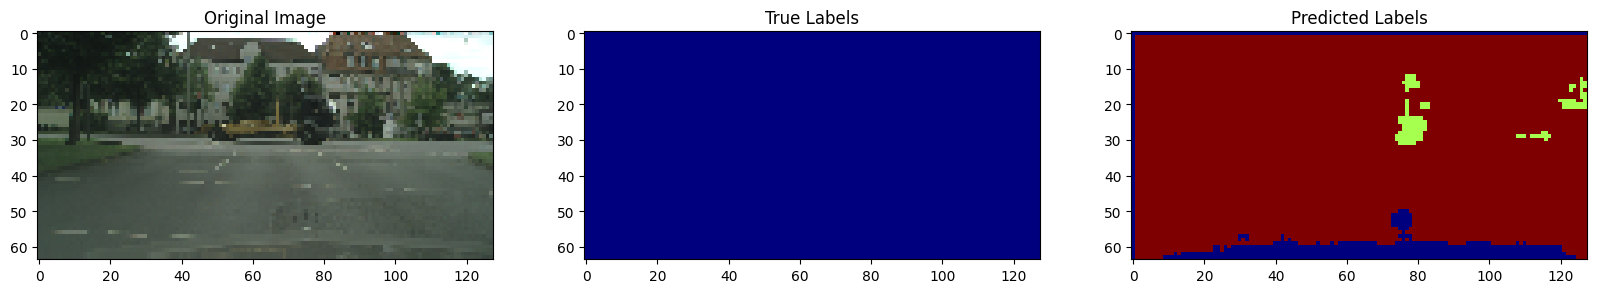

2024-06-26 01:41:51.752397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import matplotlib.pyplot as plt

# Fetch one batch of test data and predict
for img, true_labels in test_dataset.take(1):
    preds = model.predict(img)
    pred_labels = np.argmax(preds, axis=-1)[0]

    # Display the original image, true labels, and predicted labels
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].imshow(img.numpy()[0])
    axes[0].set_title('Original Image')
    axes[1].imshow(np.argmax(true_labels.numpy(), axis=-1)[0], cmap='jet')
    axes[1].set_title('True Labels')
    axes[2].imshow(pred_labels, cmap='jet')
    axes[2].set_title('Predicted Labels')
    plt.show()
